# Importing libraries

In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import pulp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# keeping only mainland USA coordinates (Removing pincodes outside mainland)

In [14]:
#load the dataset (downloaded from kaggle)
df = pd.read_csv("US Zip Codes from 2013 Government Data (1).csv")

#keeping only mainland USA coordinates
df = df[
    (df["LAT"] >= 24) & (df["LAT"] <= 50) &
    (df["LNG"] >= -125) & (df["LNG"] <= -66)
]
df.to_csv("US Zip Codes from 2013 Government Data_1.csv", index=False)


ZIP dataset loaded: (32657, 3)

Optimal Fulfillment Centers Selected:
FC 1: (lat=41.61, lon=-96.50)
FC 2: (lat=41.65, lon=-79.73)
FC 3: (lat=45.02, lon=-89.53)
FC 6: (lat=38.13, lon=-93.03)
FC 9: (lat=47.36, lon=-92.96)

 Customer Assignments:


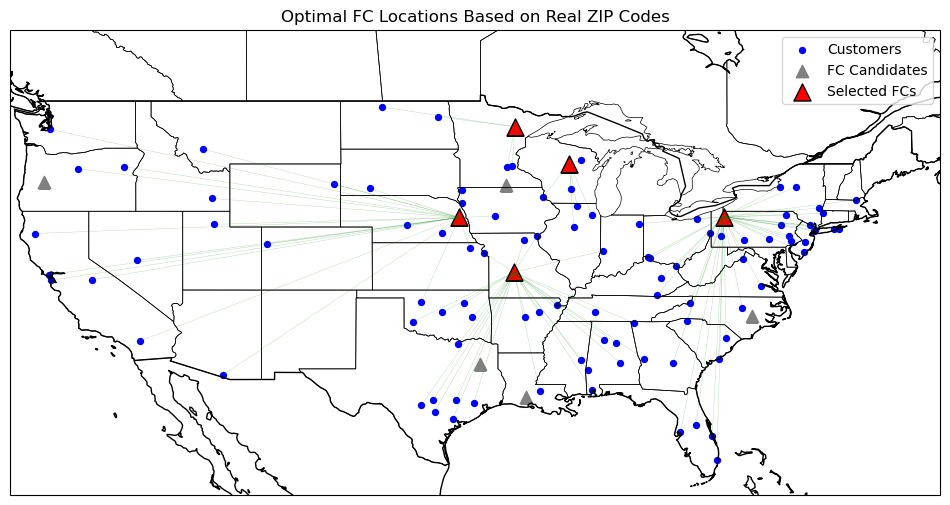

In [16]:
#-------------------------
#loading the zip code data
#-------------------------
df = pd.read_csv("US Zip Codes from 2013 Government Data_1.csv")

# Use only valid rows
df = df.dropna(subset=['LAT', 'LNG'])

print("ZIP dataset loaded:", df.shape)

#-------------------------
#SAMPLE CUSTOMERS + FCs
#-------------------------
num_customers = 100
num_fc = 10
k = 5 # choose k FCs optimally

# Sample customers
cust_sample=df.sample(num_customers, random_state=23)
cust_lats=cust_sample["LAT"].values
cust_lons=cust_sample["LNG"].values
customers=  np.column_stack((cust_lats, cust_lons))

# Sample FC candidate locations
fc_sample =  df.sample(num_fc, random_state=99)
fc_lats =fc_sample["LAT"].values
fc_lons = fc_sample["LNG"].values
fc_locations= np.column_stack((fc_lats, fc_lons)) 

# opening cost of opening each fc
opening_cost =np.random.randint(50000, 150000, num_fc) #assigns random cost from 50000 to 150000 for different FC
# Random demand for customers
demand = np.random.randint(10, 100, num_customers)

#-------------------------
#DISTANCE + COST MATRIX
#-------------------------
dist_matrix = cdist(customers, fc_locations, metric="euclidean")
cost_matrix = dist_matrix * demand.reshape(-1, 1)

#-------------------------
# LINEAR PROGRAMMING (using PuLP library)
#-------------------------
model = pulp.LpProblem("Ecommerce_FC_Optimization", pulp.LpMinimize)

#decision variables
x = pulp.LpVariable.dicts("Assign",
                          (range(num_customers), range(num_fc)),
                          0, 1, pulp.LpBinary)

y = pulp.LpVariable.dicts("OpenFC",
                          range(num_fc),
                          0, 1, pulp.LpBinary)

# Objective
model += (
    pulp.lpSum(cost_matrix[i][j] * x[i][j]
               for i in range(num_customers)
               for j in range(num_fc))
    +
    pulp.lpSum(opening_cost[j] * y[j] for j in range(num_fc))
)


#open exactly k FCs
model += pulp.lpSum(y[j] for j in range(num_fc)) == k

#Each customer assigned to 1 FC
for i in range(num_customers):
    model += pulp.lpSum(x[i][j] for j in range(num_fc)) == 1

# Assignment allowed only if FC opened
for i in range(num_customers):
    for j in range(num_fc):
        model += x[i][j] <= y[j]

#load constraint(<50% of total demand)
total_demand = demand.sum()
max_fc_load = 0.5 * total_demand

for j in range(num_fc):
    model += pulp.lpSum(demand[i] * x[i][j] for i in range(num_customers)) <= max_fc_load

# Solve
model.solve(pulp.PULP_CBC_CMD(msg=False))

#-------------------------
#showing output results
#-------------------------
print("\nOptimal Fulfillment Centers Selected:")
chosen_fc = []
for j in range(num_fc):
    if pulp.value(y[j]) == 1:
        chosen_fc.append(j)
        print(f"FC {j}: (lat={fc_lats[j]:.2f}, lon={fc_lons[j]:.2f})")

print("\n Customer Assignments:")
assignments = {}
for i in range(num_customers):
    for j in chosen_fc:
        if pulp.value(x[i][j]) == 1:
            assignments[i] = j
#-------------------------
#PLOTTING USA MAP
#-------------------------
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -66, 24, 50])

#map features(showing united states map)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

#plot customer location
plt.scatter(cust_lons, cust_lats,
            color="blue", s=18,
            label="Customers",
            transform=ccrs.PlateCarree())

#plot potential locations of FCs
plt.scatter(fc_lons, fc_lats,
            color="gray", s=80, marker="^",
            label="FC Candidates",
            transform=ccrs.PlateCarree())

#plot selected FCs
plt.scatter(fc_lons[chosen_fc], fc_lats[chosen_fc],
            color="red", edgecolor="black",
            s=150, marker="^",
            label="Selected FCs",
            transform=ccrs.PlateCarree())

# Assignment lines
for cust_idx, fc_idx in assignments.items():
    plt.plot([cust_lons[cust_idx], fc_lons[fc_idx]],
             [cust_lats[cust_idx], fc_lats[fc_idx]],
             linewidth=0.3, alpha=0.3, color="green",
             transform=ccrs.PlateCarree())

plt.title("Optimal FC Locations Based on Real ZIP Codes")
plt.legend()
plt.show()
